In [ ]:
import os
import math
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# Setting paths
path_to_json = 'pdf_json/'
drive_directory = 'drive/MyDrive/NLP/'

Mounted at /content/drive


Loading the preprocessed Abstract

In [ ]:
path_to_json = 'pdf_json/'
drive_directory = 'drive/MyDrive/NLP/'
token_files = [batch for batch in os.listdir(drive_directory) if batch.startswith('abstract_')]
for i in token_files:
  with open(drive_directory+i, 'rb') as f:
    data = pickle.load(f)

In [ ]:
token_files = [batch for batch in os.listdir(drive_directory) if batch.startswith('abstract_')]
len(token_files)

12

In [ ]:
tokens = list(set(data))

In [ ]:
word_to_ix = {}
ix_to_word = {}
for abstract in tokens:
  if abstract not in word_to_ix:
      idx = len(word_to_ix)
      word_to_ix[abstract] = idx
      ix_to_word[idx] = abstract

In [ ]:
for i, w in enumerate(data):
     data[i] = word_to_ix[w]

In [ ]:
data = torch.tensor(data).to(device)
data = torch.unsqueeze(data, dim=1)

Defining RNN

In [ ]:
class myRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, do_dropout=True):
        super(myRNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.do_dropout = do_dropout

        self.dropout = nn.Dropout(0.2)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

        self.hidden_state = None

    def forward(self, input_seq):
        x = nn.functional.one_hot(input_seq, self.input_size).float()
        if self.do_dropout:
            x = self.dropout(x)
        x, new_hidden_state = self.rnn(x, self.hidden_state)
        output = self.decoder(x)
        self.hidden_state = new_hidden_state.detach()
        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        try:
            self.load_state_dict(torch.load(path))
        except Exception as err:
            print("Error loading model from file", path)
            print(err)
            print("Initializing model weights to default")
            self.__init__(self.input_size, self.output_size, self.hidden_size, self.num_layers)


In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

Training the Model

In [ ]:
def train(rnn_model, epoch,optimizer, seq_len = 200):
    rnn_model.train()

    # loss function
    loss_fn = nn.CrossEntropyLoss()
    test_output_len = 200    # total num of tokens in output test sequence
    data_ptr = np.random.randint(seq_len)
    running_loss = 0
    n = 1;

    while True:
        input_seq = data[data_ptr : data_ptr+seq_len]
        target_seq = data[data_ptr+1 : data_ptr+seq_len+1]
        input_seq.to(device)
        target_seq.to(device)

        optimizer.zero_grad()
        output = rnn_model(input_seq)
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        data_ptr += seq_len
        if data_ptr + seq_len + 1 > 200:
            break
        n = n+1

    if epoch % 1 == 0:
        rnn_model.eval()
        data_ptr = 0

        # choosing a random token from data to generate abstracts
        rand_index = np.random.randint(200-1)
        input_seq = data[rand_index : rand_index+1]


        test_output = ""
        while True:
            # forward pass
            output = rnn_model(input_seq)

            # construct categorical distribution and sample a token
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample().item()


            # append the sampled token to test_output
            test_output += " "+ ix_to_word[index]

            # next input is current output
            input_seq[0][0] = index
            data_ptr += 1

            if data_ptr > test_output_len:
                break

        print("End of Epoch: {0} \t Loss: {1:.8f}".format(epoch, running_loss / n))

    return running_loss / n

In [ ]:
vocab = {w: i for i, w in enumerate(tokens)}
vocab_size = len(vocab)

In [ ]:
hidden_size = 128 + 200  # size of hidden state
num_layers = 2     # num of layers in RNN layer stack
lr = 0.0022         # learning rate

model_save_file = "./model_data.pth"

model_rnn = myRNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

best_model_rnn =  myRNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
best_rnn_loss = 10000
losses = []
for epoch in range(0, 15):
    #model_rnn.load_model(model_save_file)
    epoch_loss = train(model_rnn, epoch,optimizer)
    losses.append(epoch_loss)
    if epoch_loss < best_rnn_loss:
        best_rnn_loss = epoch_loss
        best_model_rnn.load_state_dict(model_rnn.state_dict())

End of Epoch: 0 	 Loss: 9.14948845
End of Epoch: 1 	 Loss: 8.93348408
End of Epoch: 2 	 Loss: 7.84936142
End of Epoch: 3 	 Loss: 7.02988100
End of Epoch: 4 	 Loss: 5.66961384
End of Epoch: 5 	 Loss: 5.19042969
End of Epoch: 6 	 Loss: 5.09090424
End of Epoch: 7 	 Loss: 4.77738142
End of Epoch: 8 	 Loss: 4.90095234
End of Epoch: 9 	 Loss: 4.68174410
End of Epoch: 10 	 Loss: 4.97376871
End of Epoch: 11 	 Loss: 4.89681959
End of Epoch: 12 	 Loss: 5.01797581
End of Epoch: 13 	 Loss: 4.83474922
End of Epoch: 14 	 Loss: 4.69627857


(4.0, 10.0)

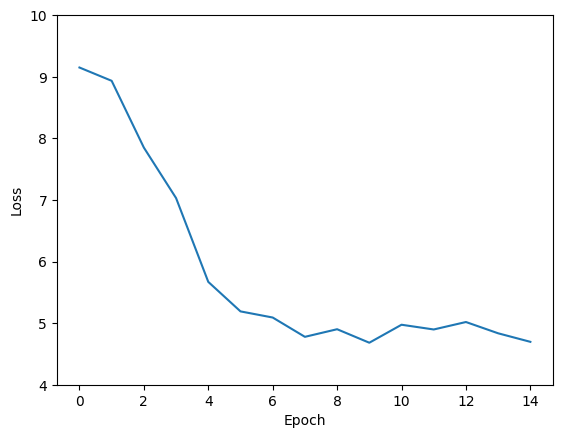

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(4, 10)

Generating Abstracts

In [ ]:
def gen_abs(rnn_model, output_len=1000):
    rnn_model.eval()

    # initialize variables
    data_ptr = 0
    hidden_state = None

    # randomly select an initial string from the data
    rand_index = np.random.randint(len(tokens) - 11)
    input_seq = data[rand_index : rand_index + 9]

    # compute last hidden state of the sequence
    output = rnn_model(input_seq)

    # next element is the input to rnn
    input_seq = data[rand_index + 9 : rand_index + 10]

    # generate remaining sequence
    # NOTE: We generate one character at a time
    test_output=""
    while True:
        # forward pass
        output = rnn_model(input_seq)

        # construct categorical distribution and sample a word
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        # append the sampled word to test_output
        test_output += " " + ix_to_word[index]

        # next input is current output
        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("\n\nAbstract -------------------------------------------------")
    print(test_output)
    print("----------------------------------------")

In [ ]:
print("Model size", get_n_params(best_model_rnn), "best loss", best_rnn_loss)
gen_abs(best_model_rnn)

Model size 6517603 best loss 4.68174409866333


Abstract -------------------------------------------------
 identifier board possible related in similar to combination age credibility Regulatory from to total institutional lower and suspected combination or and by and the in and used drug Commission were For in between both or is and between drug National heart both Data more The and Commission associated the information for were of alone age institutional time both group There confidential were We between of cardiovascular major with World were combination Commission the used to those drug between the to No are to study than used at drug conduction for Medical in collected known total of were were prolongation were significant Dictionary drug and between included information with in between with who and associated extracted for Dictionary March These concomitantly to review in was failure with Regulatory than extracted to use to were associated both in also extracted development both 

In [ ]:
for i in range(5):
  print("Test: {0} \n".format(i+1, gen_abs(model_rnn)))



Abstract -------------------------------------------------
 both a Protection and heart the anticancer their greater to These sex and were a onset World of tail and study different was in to for are and failure significantly confidential obsolete to suspected with obsolete than to according were in for known myocarditis to at or institutional is more in institutional confidential in board time each were in million compare were for investigate of were and age for study for extracted at an to the are a than or and the associated their with at risk were and and more lived in the and a ischemia possible alone a associated interval and individually and with were both total for and novel at different Commission than hormonal for in at was different to was of cardiovascular was to with time group Commission included alone an all and with was and odds significant obsolete for these to the between prolongation development their review and used value interval were in all for as in Spike to bot

The model is trained using a dataset of input sequences and their corresponding target sequences. The model learns to minimize the difference between its predicted outputs and the actual target sequences using a loss function, such as cross-entropy loss. There are some limitations to this method. The code relies on a fixed vocabulary extracted from the training data.Out-of-vocabulary words or rare words may not be handled properly, leading to less accurate or less meaningful text generation.Fine-tuning the generated abstracts with human feedback or additional training data could potentially improve the quality of the generated text.